In [18]:
import sys
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(parent_directory)
sys.path.append(project_directory + "/transition_path_sampling")
sys.path.append(project_directory + "/transition_path_generation")
import numpy as np
import csv
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from networks.tp_conditional_chain.conditional_net import NeuralNet as net1
import helpers
import math
import muller
import torch
import scipy

In [7]:
grid_size = 100
x_start = -2.5
x_end = 1.5
y_start = -1
y_end = 2.5
def plot_contours(drift_func):
    x_grid, y_grid = np.meshgrid(np.linspace(x_start, x_end, grid_size), np.linspace(y_start, y_end, grid_size))
    z_grid = np.zeros((x_grid.shape[0], x_grid.shape[1]))
    tics = np.linspace(-150, 150, 30)
    for i in range(x_grid.shape[0]):
        for j in range(x_grid.shape[1]):
            z_grid[i] = drift_func.get_potential(np.vstack([x_grid[i], y_grid[i]]).T)
    CS = plt.contour(x_grid, y_grid, z_grid, tics)
    plt.clabel(CS, inline=False, fontsize=10)

In [8]:
def visualize(data, drift_func=muller):
    plot_contours(drift_func)
    for i in range(data.shape[0]):
        plt.plot(data[i,:,0], data[i,:,1])
        plt.xlim([-2.5, 1.5])
        plt.ylim([-1, 2.5])
        plt.xlabel("X")
        plt.ylabel("Y")
    plt.show()

In [9]:
def forward_gen(x, t_vals, beta, mu):
    for i in range(t_vals.shape[0]):
        if i == 0:
            x_diff = np.random.normal(size=x.shape) * np.sqrt(t_vals[i])
            x = x - beta * (x - np.tile(mu, (x.shape[0], x.shape[1], 1))) * (t_vals[i]) + x_diff
        else:
            x_diff = np.random.normal(size=x.shape) * np.sqrt(t_vals[i] - t_vals[i-1])
            x = x - beta * (x - np.tile(mu, (x.shape[0], x.shape[1], 1))) * (t_vals[i] - t_vals[i-1]) + x_diff
    return x

In [21]:
def backward_gen(x, func, t_vals, beta, mu, times, plot=True):
    l = t_vals.shape[0]
    if times.shape[0] == x.shape[0]:
        path_t = torch.tensor(times).float()
    else:
        print("invalid times")
        path_t = torch.ones(x.shape[0]) * 0.02
    for i in tqdm(range(t_vals.shape[0])):
        if i % (t_vals.shape[0]//8) == 0 and plot:
            visualize(x[:10])
        if i == l - 1:
            step = t_vals[l - i - 1]
        else:
            step = t_vals[l - i - 1] - t_vals[l - i - 2]
        x_stoc = np.random.normal(size=x.shape) * np.sqrt((np.exp((2 * beta) * step) - 1)/(2 * beta))
        score = np.zeros_like(x)
        for j in range(x.shape[1]):
            t_2 = j / x.shape[1]
            if j == x.shape[1] - 1:
                score[:, j] += func.forward_score(torch.tensor(x[:, j]).float(), t_vals[l - i - 1], torch.tensor(x[:, j-1]).float(), t_2, path_t).detach().numpy()
            elif j == 0:
                score[:, j] += func.backward_score(torch.tensor(x[:, j]).float(), t_vals[l - i - 1], torch.tensor(x[:, j+1]).float(), t_2, path_t).detach().numpy()
                score[:, j] += func.initial_score(torch.tensor(x[:, j]).float(), t_vals[l - i - 1], path_t).detach().numpy()
            else:
                score[:, j] += func.forward_score(torch.tensor(x[:, j]).float(), t_vals[l - i - 1], torch.tensor(x[:, j-1]).float(), t_2, path_t).detach().numpy()
                score[:, j] += func.backward_score(torch.tensor(x[:, j]).float(), t_vals[l - i - 1], torch.tensor(x[:, j+1]).float(), t_2, path_t).detach().numpy()
        x_drift = (1 / beta) * (np.exp(beta * step) - 1) * score + np.exp(beta * step) * x
        x = x_stoc + x_drift
    return x

In [22]:
nn_path = project_directory + "/data/nets/chain_test"
output_path = project_directory + '/data/transition_paths/chain_test'

save = True

net = net1

mu = torch.tensor([0,0])
sig_min = 0.005
const = 2.2
n = 105
beta = 0.5
tp_len = 9

vals = helpers.get_times(sig_min, const, n, beta).detach().numpy()
t_vals = vals[:,0]
h_vals = vals[:,1]
sigmas = vals[:,2]
print(max(t_vals))

7.7644806


In [23]:
learning_rate = 0.01
model = net(beta, mu)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

checkpoint = torch.load(nn_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
min_sigma = checkpoint['min_sigma']

model.eval()

/home/users/lft4/diffusion_tp_generation/transition_path_generation/networks/tp_conditional_chain/forward_module.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)
/home/users/lft4/diffusion_tp_generation/transition_path_generation/networks/tp_conditional_chain/forward_module.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc2.weight)
/home/users/lft4/diffusion_tp_generation/transition_path_generation/networks/tp_conditional_chain/forward_module.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc3.weight)
/home/users/lft4/diffusion_tp_generation/transition_path_generation/networks/tp_conditional_chain/forward_module.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.in

NeuralNet(
  (forward_score): ForwardModule(
    (fc1): Linear(in_features=7, out_features=20, bias=True)
    (tanh1): Tanh()
    (fc2): Linear(in_features=20, out_features=400, bias=True)
    (tanh2): LeakyReLU(negative_slope=0.01)
    (fc3): Linear(in_features=400, out_features=400, bias=True)
    (tanh3): LeakyReLU(negative_slope=0.01)
    (fc4): Linear(in_features=400, out_features=200, bias=True)
    (tanh4): Tanh()
    (fc5): Linear(in_features=200, out_features=20, bias=True)
    (fin_relu): LeakyReLU(negative_slope=0.01)
    (fin): Linear(in_features=20, out_features=2, bias=True)
  )
  (backward_score): BackwardModule(
    (fc1): Linear(in_features=7, out_features=20, bias=True)
    (tanh1): Tanh()
    (fc2): Linear(in_features=20, out_features=400, bias=True)
    (tanh2): LeakyReLU(negative_slope=0.01)
    (fc3): Linear(in_features=400, out_features=400, bias=True)
    (tanh3): LeakyReLU(negative_slope=0.01)
    (fc4): Linear(in_features=400, out_features=200, bias=True)
    

In [24]:
data_path = project_directory + '/data/transition_paths/muller_tps.txt'
file = open(data_path)
csvreader = csv.reader(file)

c = 0
tps = []
for row in csvreader:
    if c > 300:
        break
    arr = np.zeros((len(row), 2))
    for i in range(arr.shape[0]):
        str_list = row[i].strip('[]').split()
        arr[i] = np.array([float(num) for num in str_list])
    arr.astype(float)
    tps.append(arr)
    c+=1
file.close()

arr = np.array(tps).astype(float)
arr = helpers.reshape_ts_np(arr, tp_len)
times = arr[:,-1,0]
arr = arr[:,:-1]
print(arr.shape)

(301, 9, 2)


In [28]:
num_samples = 200

params = scipy.stats.lognorm.fit(times)
dist = scipy.stats.lognorm
X = np.linspace(0,0.07, 10)
pdf_fitted = dist.pdf(X, *params)

times = dist.rvs(params[0], params[1], params[2], size=num_samples)
print(times)
print(np.mean(times))

[0.01112256 0.02757588 0.03376364 0.02981009 0.01944343 0.01538649
 0.02971558 0.01659254 0.01441992 0.01505052 0.01203052 0.01291071
 0.01152983 0.03627012 0.02392997 0.01428076 0.01133091 0.00803962
 0.01270183 0.02667818 0.04805751 0.02224017 0.01140824 0.019731
 0.01595746 0.01048634 0.03771221 0.01607204 0.01165835 0.02150195
 0.01857552 0.00833636 0.00732049 0.01751458 0.00868957 0.01604662
 0.01356345 0.0332644  0.02873525 0.00887596 0.01864438 0.01563905
 0.02117693 0.02133985 0.0240146  0.01384768 0.01626897 0.02449547
 0.01139921 0.01620131 0.02589572 0.019645   0.02004571 0.02276537
 0.01618369 0.01170744 0.02073297 0.00930358 0.01236088 0.01662838
 0.01846166 0.01155598 0.0238396  0.01847331 0.01493175 0.01495177
 0.01534481 0.02198036 0.00713085 0.01283568 0.04558341 0.02547271
 0.01422907 0.01993142 0.01712844 0.02181482 0.02246038 0.01709396
 0.0118653  0.04481851 0.02597513 0.0106194  0.00845442 0.02803719
 0.01948327 0.02117476 0.07239604 0.03634266 0.02237929 0.025821

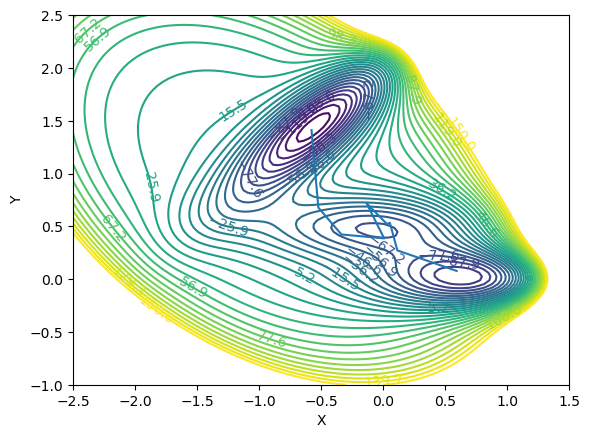

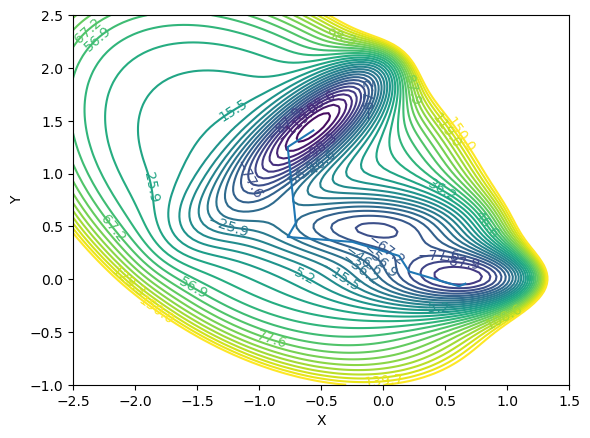

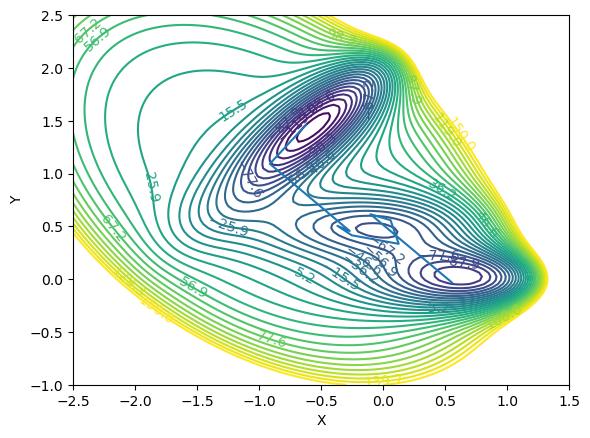

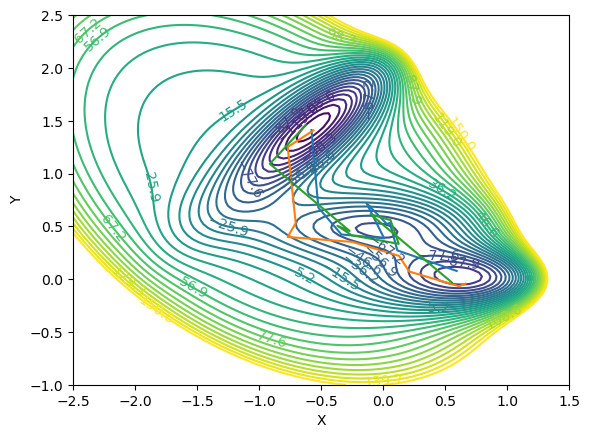

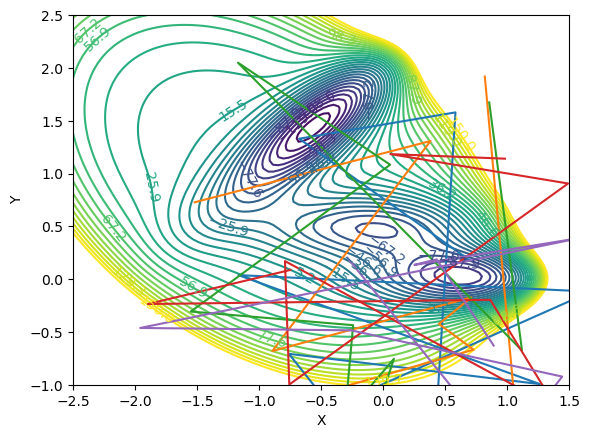

  0%|          | 0/105 [00:00<?, ?it/s]

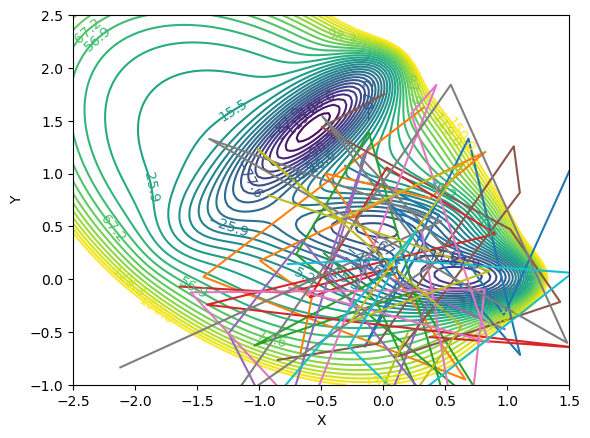

 12%|█▏        | 13/105 [00:18<02:01,  1.32s/it]

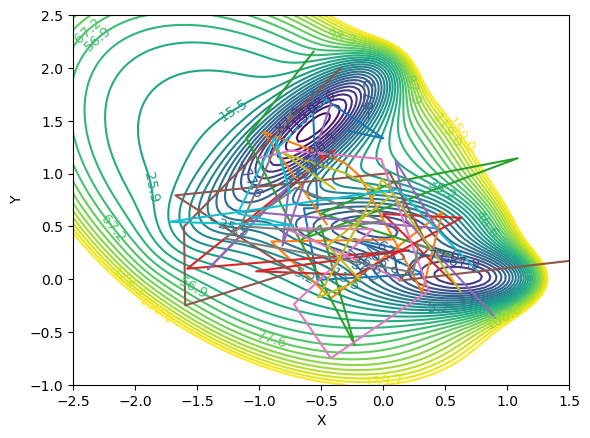

 25%|██▍       | 26/105 [00:26<00:36,  2.16it/s]

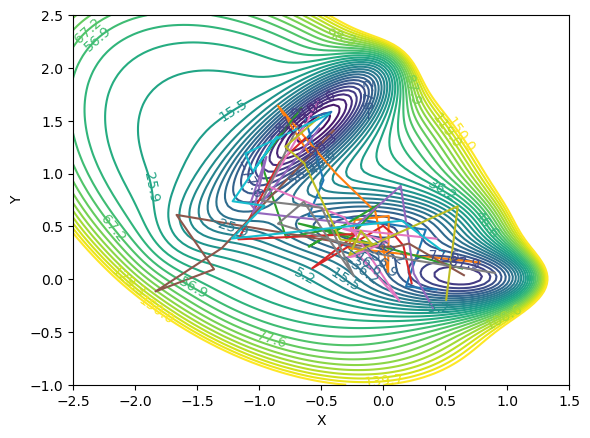

 37%|███▋      | 39/105 [00:39<00:46,  1.41it/s]

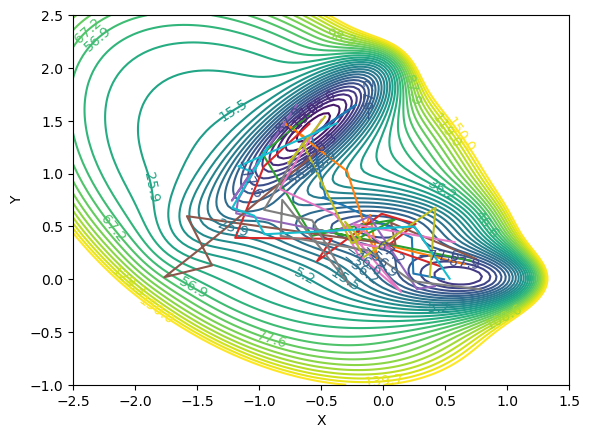

 50%|████▉     | 52/105 [00:47<00:30,  1.73it/s]

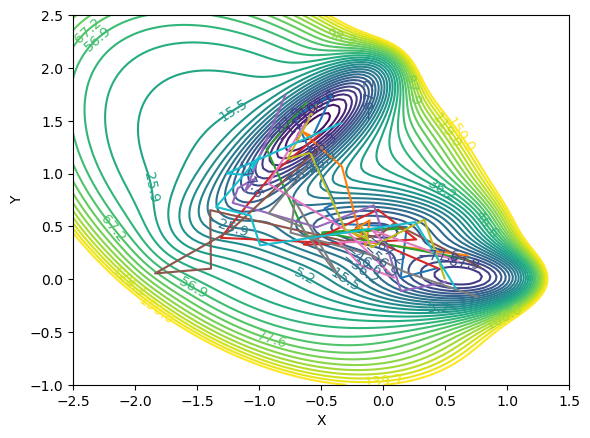

 62%|██████▏   | 65/105 [01:04<00:48,  1.22s/it]

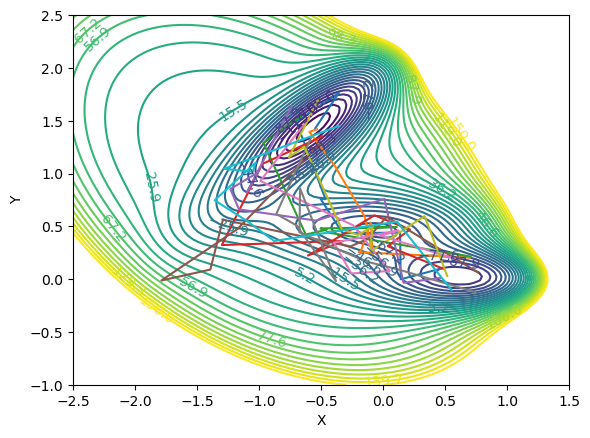

 74%|███████▍  | 78/105 [01:20<00:30,  1.11s/it]

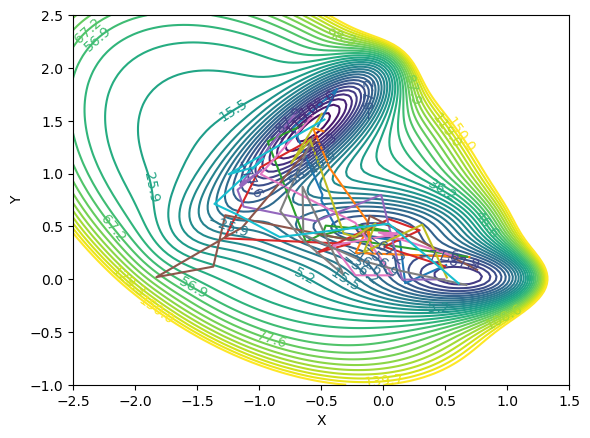

 87%|████████▋ | 91/105 [01:41<00:20,  1.49s/it]

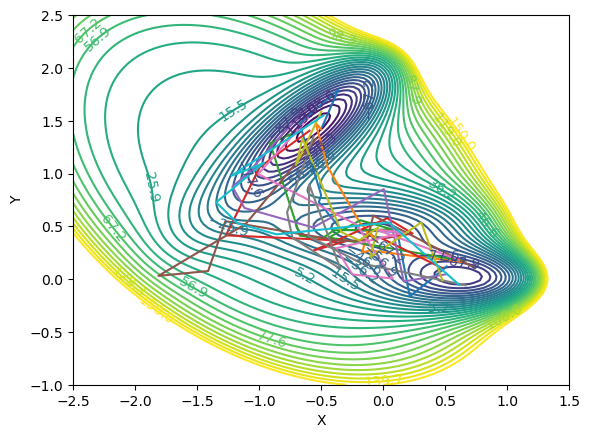

 99%|█████████▉| 104/105 [01:57<00:01,  1.13s/it]

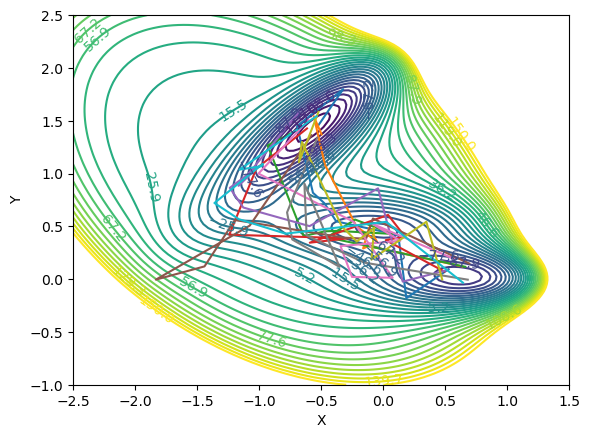

100%|██████████| 105/105 [02:01<00:00,  1.16s/it]


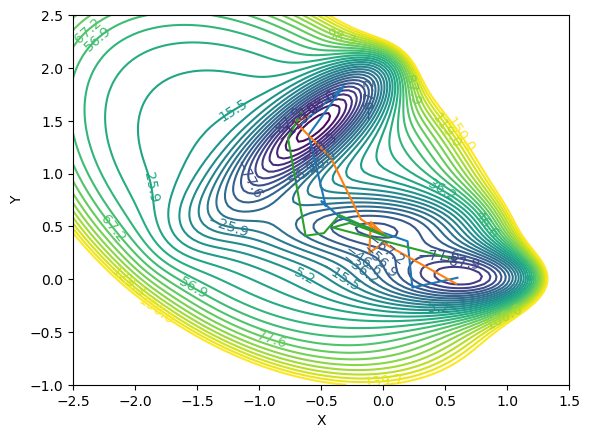

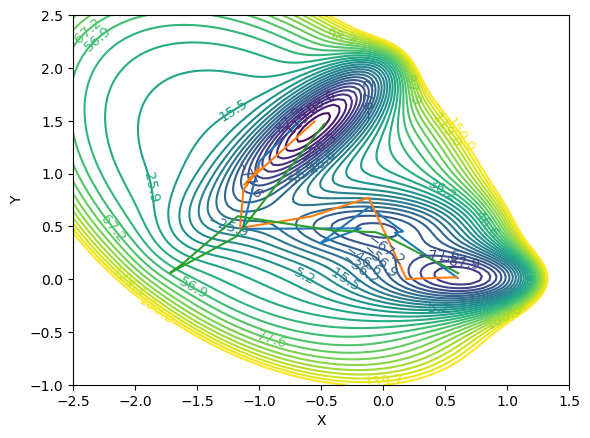

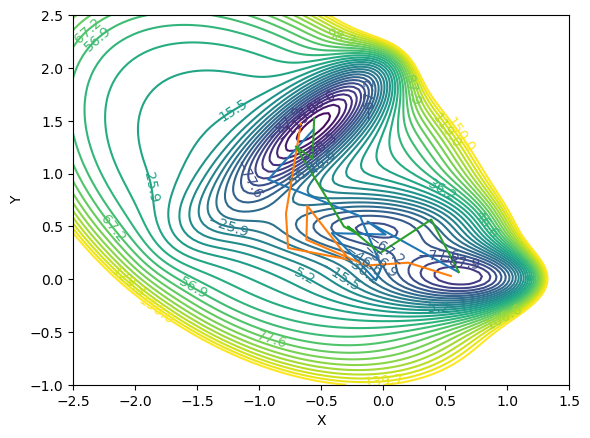

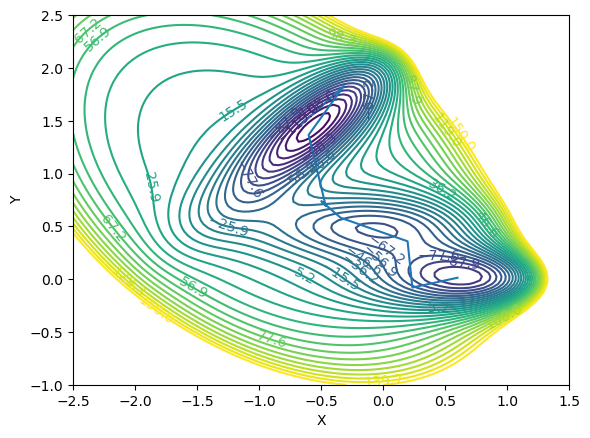

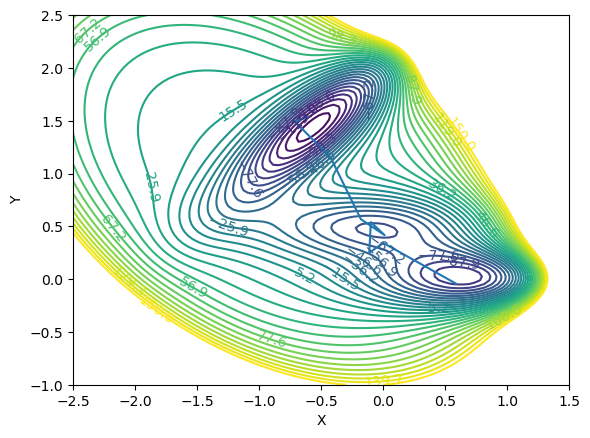

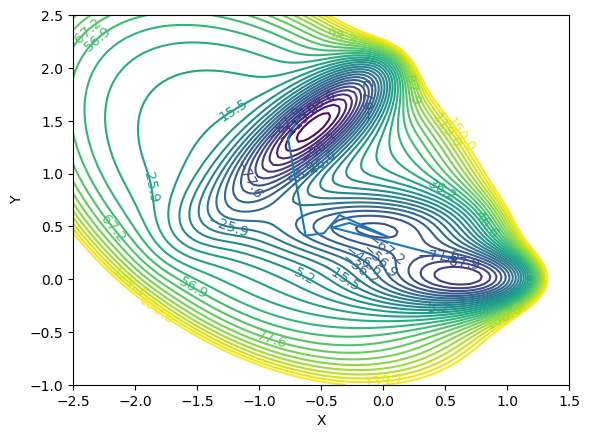

In [29]:
visualize(data=arr[0:1])
visualize(data=arr[1:2])
visualize(data=arr[2:3])
visualize(data=arr[0:3])

data = forward_gen(arr, t_vals, beta, mu)
visualize(data=data[0:5])

#no mu
data = np.random.normal(size=(num_samples, tp_len, 2)) * (np.sqrt((1 - np.exp(-2 * beta * max(t_vals))) / (2 * beta)).item())
data = backward_gen(data, model, t_vals, beta, mu, times, plot=True)

visualize(data=data[0:3])
visualize(data=data[3:6])
visualize(data=data[6:9])
visualize(data=data[0:1])
visualize(data=data[1:2])
visualize(data=data[2:3])

In [30]:
if save:
    with open(output_path, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)